## CODE
#### Imports


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import MyUtils
from importlib import reload
import UNet
import pickle

#### User Input Data


In [2]:
path_images = "D:\\Work\\Sarbazi\\data\\dataset"
path_masks = "D:\\Work\\Sarbazi\\data\\dataset\\manual segmentation"
batch_size = 4
image_shape = (1024, 768)

#### Data Generation


In [5]:
MyUtils = reload(MyUtils)
id_all_data = MyUtils.get_id_all_data(path_masks)
id_training_data, id_testing_data = MyUtils.split_train_test_id(id_all_data,testing_share=0.2)
training_data = MyUtils.DataGenerator(path_images, path_masks, id_training_data, batch_size, image_shape)
testing_data = MyUtils.DataGenerator(path_images, path_masks, id_testing_data, 20, image_shape, shuffle=False)

(1340, 960)
(1187, 890)
(1152, 864)
(1356, 1018)


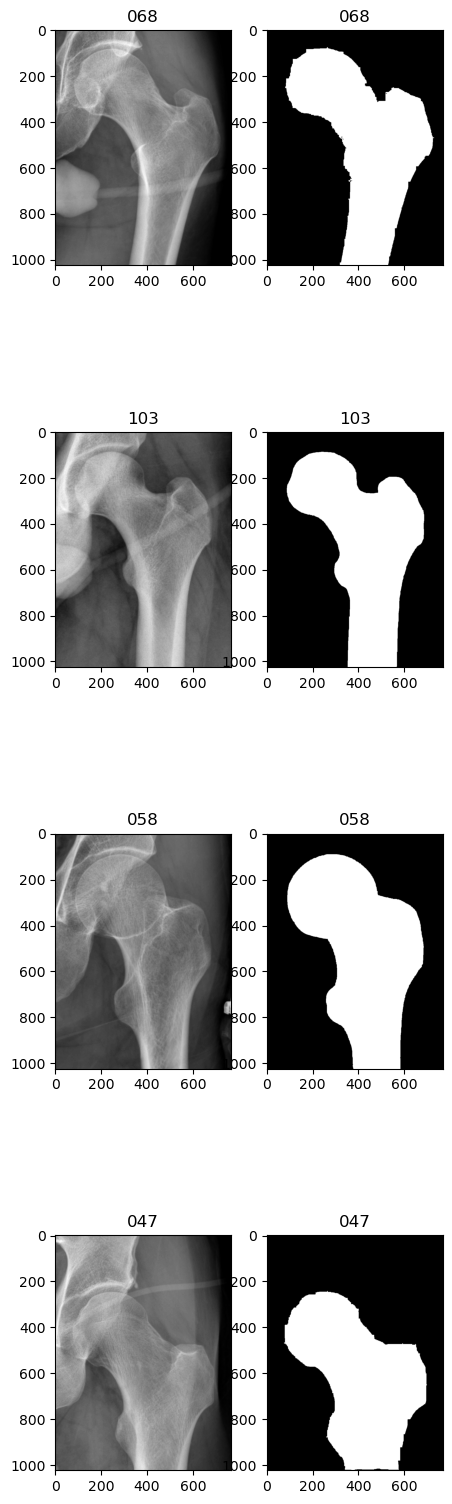

In [6]:
batch_id = 0
sample_batch_image, sample_batch_mask = training_data.__getitem__(batch_id)
img_ids = training_data._get_image_ids(batch_id)
fig, ax = plt.subplots(4, 2, figsize=(5, 20))
for i in range(batch_size):
    ax[i, 0].imshow(sample_batch_image[i,:,:,0],cmap='gray')
    ax[i, 0].set_title(str(img_ids[i]).zfill(3))
    ax[i, 1].imshow(sample_batch_mask[i,:,:,0],cmap='gray')
    ax[i, 1].set_title(str(img_ids[i]).zfill(3))

#### Create U-Net


In [8]:
UNet = reload(UNet)
MyUtils = reload(MyUtils)
UNetModel = UNet.create_UNet((*image_shape,1), (*image_shape,1))
UNetModel.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
# UNetModel.compile(optimizer="adam", loss=MyUtils.dice_coef_loss, metrics=[MyUtils.dice_coef])
UNetModel.summary(line_length=120)

Model: "model"
________________________________________________________________________________________________________________________
 Layer (type)                          Output Shape               Param #       Connected to                            
 input_1 (InputLayer)                  [(None, 512, 384, 1)]      0             []                                      
                                                                                                                        
 conv2d (Conv2D)                       (None, 512, 384, 4)        40            ['input_1[0][0]']                       
                                                                                                                        
 conv2d_1 (Conv2D)                     (None, 512, 384, 4)        148           ['conv2d[0][0]']                        
                                                                                                                        
 max_pooling2d (M

In [13]:
UNetModel.fit(training_data, validation_data=testing_data, epochs=50, workers=10)

Epoch 1/50
20/20 [==============================] - 15s 625ms/step - loss: 0.2273 - acc: 0.9053 - val_loss: 0.2204 - val_acc: 0.9430
Epoch 2/50
20/20 [==============================] - 10s 397ms/step - loss: 0.1320 - acc: 0.9516 - val_loss: 0.1819 - val_acc: 0.9297
Epoch 3/50
20/20 [==============================] - 9s 405ms/step - loss: 0.1064 - acc: 0.9598 - val_loss: 0.0923 - val_acc: 0.9669
Epoch 4/50
20/20 [==============================] - 9s 407ms/step - loss: 0.0782 - acc: 0.9720 - val_loss: 0.0831 - val_acc: 0.9695
Epoch 5/50
20/20 [==============================] - 9s 399ms/step - loss: 0.0919 - acc: 0.9644 - val_loss: 0.1178 - val_acc: 0.9515
Epoch 6/50
20/20 [==============================] - 9s 383ms/step - loss: 0.0813 - acc: 0.9684 - val_loss: 0.0847 - val_acc: 0.9678
Epoch 7/50
20/20 [==============================] - 9s 400ms/step - loss: 0.0513 - acc: 0.9801 - val_loss: 0.0630 - val_acc: 0.9750
Epoch 8/50
20/20 [==============================] - 9s 413ms/step - loss: 

In [14]:
# UNetModel.save_weights('UNetModel_weights.h5')
UNetModel.save('UNetModel.h5', save_traces=True)

In [5]:
# UNetModel.load_weights('UNetModel_weights.h5')
UNetModel = UNet.keras_models.load_model('UNetModel.h5')

In [6]:
batch_id = 0
sample_test_image, sample_test_mask = testing_data.__getitem__(batch_id)
predict_segment = UNetModel.predict(sample_test_image)
predict_segment = (predict_segment>0.5).astype(np.bool_)

1/1 [==============================] - 3s 3s/step


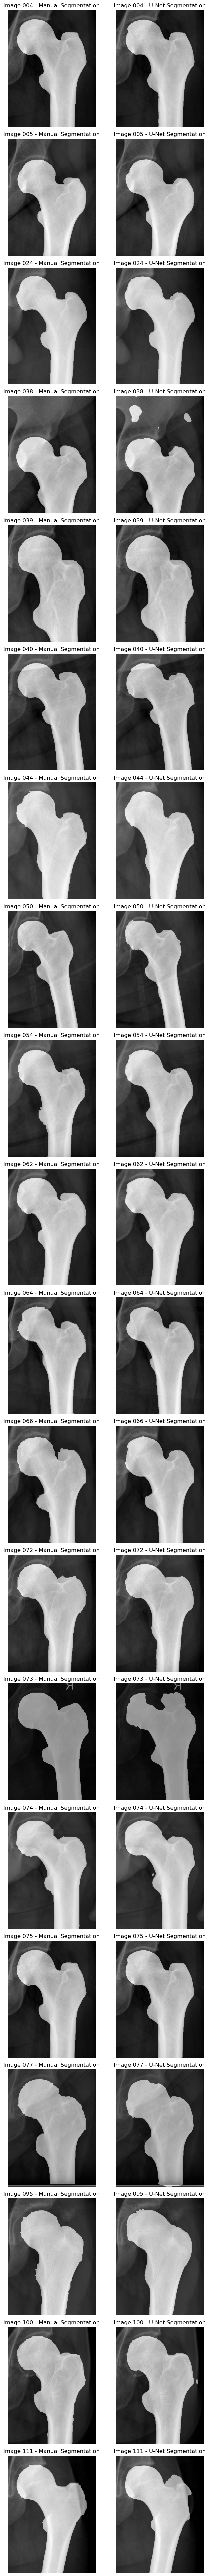

In [7]:
fig, axs = plt.subplots(sample_test_image.shape[0], 2, figsize=(8,100))
titles = [str(i).zfill(3) for i in testing_data._get_image_ids(batch_id)]
for i in range(sample_test_image.shape[0]):
    axs[i,0].imshow(sample_test_image[i,:,:,0], cmap='gray')
    axs[i,0].imshow(sample_test_mask[i,:,:,0],cmap='gray',alpha=0.5)
    axs[i,0].set_title("Image %s - Manual Segmentation" % (titles[i]))
    axs[i,0].axis('off')
    axs[i,1].imshow(sample_test_image[i,:,:,0], cmap='gray')
    axs[i,1].imshow(predict_segment[i,:,:,0],cmap='gray',alpha=0.5)
    axs[i,1].set_title("Image %s - U-Net Segmentation" % (titles[i]))
    axs[i,1].axis('off')
plt.subplots_adjust(hspace=0.1, wspace=0.1)

In [8]:
with open('out.png','wb') as f:
    fig.savefig(f, dpi=600)